# Импорт библиотек

In [195]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn
from sklearn.preprocessing import LabelEncoder# Импортируем LabelEncoder от scikit-learn

from sklearn.compose import TransformedTargetRegressor

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

from sklearn.linear_model import SGDRegressor # Линейная регрессия с градиентным спуском от scikit-learn

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.linear_model import Lasso # L1-регуляризация
from sklearn.linear_model import Ridge # L2-регуляризация

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

import sklearn.datasets as ds
from sklearn import preprocessing as prep

from sklearn.metrics import silhouette_samples # функция scikit-learn для оценки Коэффициента Силлуэта

import matplotlib # библиотека Matplotlib для визуализации

from sklearn.cluster import KMeans # Кластеризация К-Средних от scikit-learn

In [196]:
import warnings
warnings.filterwarnings('ignore')

In [197]:
from sklearn.model_selection import RandomizedSearchCV # для поиска при случайном сэмплирование гиперпараметров
import scipy.stats as stats # статистические функции библиотеки scipy
from scipy.stats import loguniform

In [198]:
plt.style.use('dark_background')

In [199]:
from sklearn.model_selection import GridSearchCV # для поиска по сетке гиперпараметров

from sklearn.metrics import make_scorer #функция для создания объекта из метрики для использования в кросс-валидации

# Импорт функций

In [200]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        self.columns = X.columns

        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

    def get_feature_names_out(self, feature_names):
        return self.columns

In [201]:
def plot_multi(data, y,  names, sub, size, edgecolors = 'none', alpha = 0.5):
    axis = [[0,1],
            [2,1],
            [0,3],
            [2,3],]


    labels = [['',names[1]],
            ['',''],
            [names[0],names[3]],
            [names[2],'']]



    for n, (axi, label, ax) in enumerate(zip(axis,  labels, sub.flatten())):
        scatter = ax.scatter(data[:,axi[0]],data[:,axi[1]],
                             c=y, s = size, cmap = 'bwr',
                             alpha = alpha, facecolors = 'none' ,
                             linewidths = 2,
                             edgecolors = edgecolors);
        ax.set_ylabel(label[1], fontsize = 20)
        ax.set_xlabel(label[0], fontsize = 20)
        ax.tick_params(axis='x', labelsize= 15)
        ax.tick_params(axis='y', labelsize= 15)
        ax.grid()
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters",
                        fontsize = 15)
        ax.add_artist(legend1)

In [202]:
def vis_weigths(weights,features_names = None, width = 1200, height = 600):
    numbers = np.arange(0,len(weights))                 # создаем массив от 0 до количество весов-1
    if features_names:
        tick_labels = np.hstack(['B0',features_names])
    else:
        tick_labels = ['B'+str(num) for num in numbers] # создаем "названия" весов
    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=width,
                height=height,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = tick_labels,
                                         )
                )

    fig.show()

In [203]:
def get_coefs (model):
    B0=model.regressor_.intercept_[0]
    B=model.regressor_.coef_
    return B0, B

In [204]:
def get_coefs_1 (model):
    """Берем веса как атрибуты обученной модели.
    Входные переменные:
    ===========
    model: обученная модель
    """
    try:
        B0=model.intercept_[0]
    except IndexError:
        B0=model.intercept_
    B=model.coef_
    return B0, B

In [205]:
def print_model (B0,B,features_names):
    """Написание уравнения модели.
    Входные переменные:
    ===========
    B0: смещение (независимый коэффициент)
    weights: веса признаков
    features_names: список названий признаков
    """
    line='{:.3f}'.format(B0)
    sign=['+','-']
    for p,(fn,b) in enumerate(zip(features_names,B)):
        line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

    print('Решение')
    print(line)

In [206]:
def analyse_linear_model(model, X_train, y_train, X_val, y_val, metrics, metric_names, scoring_reg, cv_rule):
    B0, B = get_coefs_1(model)
    features_names = list(columns)
    print_model(B0,B,features_names)

    Bs = np.hstack([B0,B])
    vis_weigths(Bs,features_names)

    analyse_model(model, X_train, y_train, X_val, y_val, metrics, metric_names, scoring_reg, cv_rule)

In [207]:
def analyse_model(model, X_train, y_train, X_val, y_val, metrics, metric_names, scoring_reg, cv_rule):

    for name, metric,  in zip(metric_names, metrics):
        print(name+ f" на тренировочной выборке: {calculate_metric(model, X_train, y_train, metric):.4f}")
        print(name+ f" на валидационной выборке: {calculate_metric(model, X_val, y_val, metric):.4f}")

    cross_validation (X_train, y_train,
                    model,
                    scoring_reg,
                    cv_rule)

In [208]:
def calculate_metric(model_pipe, X, y, metric = r2_score, **kwargs):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model, **kwargs)

In [209]:
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

# Набор данных

**Предсказание цены на дом (из 2й домашки)**

Набор данных представляет собой 1460 строк и 79 переменных, описывающих (почти) каждый аспект жилых домов в Эймсе, штат Айова.

С помощью этого датасета решается задача регрессии - предсказать окончательную стоимость дома (перменная SalePrice).

Наша цель - увидеть, как те или иные признаки влияют на стоимость дома, а также их взаимосвязь друг с другом.

Так как признаков очень много, выберу по 5 самых интересующих меня категориальных и числовых признаков для будующей работы.

Выбранные числовые признаки:

LotArea (площадь участка в квадратных футах)

YearBuilt (год постройки)

BedroomAbvGr (кол-во спален выше уровня земли)

GarageArea (площадь гаража в квадратных футах)

MoSold (месяц продажи)

Выбранные категориальные признаки:

Street (тип дороги, ведущей к участку)

Utilities (тип доступных коммунальных услуг)

LotConfig (конфигурация участка)

Condition1 (близость к различным условиям)

RoofStyle (тип крыши)

Нашей целевой переменной остается SalePrice

In [210]:
df = pd.read_csv('https://raw.githubusercontent.com/dariaValerievna/Analytics/refs/heads/dariaValerievna-homework-1/train.csv', delimiter = ',') # считываем файл из интернета
df #выведем DataFrame

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [211]:
#запишем выбранные признаки в новые переменные
cat_columns_new = ['Street', 'Utilities', 'LotConfig', 'Condition1', 'RoofStyle']
num_columns_new = ['LotArea', 'YearBuilt', 'BedroomAbvGr', 'GarageArea', 'MoSold', 'SalePrice']

#удаляем из датафрейма остальные признаки
df = df.drop(columns=[col for col in df.columns if (col not in cat_columns_new) and (col not in num_columns_new)])

#выведем получившийся датафрейм
df

,LotArea,Street,Utilities,LotConfig,Condition1,YearBuilt,RoofStyle,BedroomAbvGr,GarageArea,MoSold,SalePrice
0,8450,Pave,AllPub,Inside,Norm,2003,Gable,3,548,2,208500
1,9600,Pave,AllPub,FR2,Feedr,1976,Gable,3,460,5,181500
2,11250,Pave,AllPub,Inside,Norm,2001,Gable,3,608,9,223500
3,9550,Pave,AllPub,Corner,Norm,1915,Gable,3,642,2,140000
4,14260,Pave,AllPub,FR2,Norm,2000,Gable,4,836,12,250000
...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,Pave,AllPub,Inside,Norm,1999,Gable,3,460,8,175000
1456,13175,Pave,AllPub,Inside,Norm,1978,Gable,3,500,2,210000
1457,9042,Pave,AllPub,Inside,Norm,1941,Gable,4,252,5,266500
1458,9717,Pave,AllPub,Inside,Norm,1950,Hip,2,240,4,142125


# Предварительная обработка данных

## Предварительная обработка числовых признаков

**Чистим столбцы**

In [212]:
question_lotArea = df[(df.LotArea > 1e5)]
df = df.drop(question_lotArea.index)

question_lotArea_2 = df[(df.LotArea > 16000)]
df = df.drop(question_lotArea_2.index)

question_yearBuilt = df[(df.YearBuilt < 1900)]
df = df.drop(question_yearBuilt.index)

question_garageArea = df[(df.GarageArea < 200)]
df = df.drop(question_garageArea.index)

question_garageArea_1 = df[(df.GarageArea > 1000)]
df = df.drop(question_garageArea_1.index)

df = df.reset_index(drop=True)  # обновим индексы в датафрейме DF. если бы мы прописали drop = False, то была бы еще одна колонка - старые индексы
df.tail()

,LotArea,Street,Utilities,LotConfig,Condition1,YearBuilt,RoofStyle,BedroomAbvGr,GarageArea,MoSold,SalePrice
1239,7917,Pave,AllPub,Inside,Norm,1999,Gable,3,460,8,175000
1240,13175,Pave,AllPub,Inside,Norm,1978,Gable,3,500,2,210000
1241,9042,Pave,AllPub,Inside,Norm,1941,Gable,4,252,5,266500
1242,9717,Pave,AllPub,Inside,Norm,1950,Hip,2,240,4,142125
1243,9937,Pave,AllPub,Inside,Norm,1965,Gable,3,276,6,147500


In [213]:
#удаляем все строки, в которых присутсвует хоть одно значение Nan
df = df.dropna(axis=0)

**Визуализируем**

 Видно, что все столбцы имеют относительно нормальное распределение

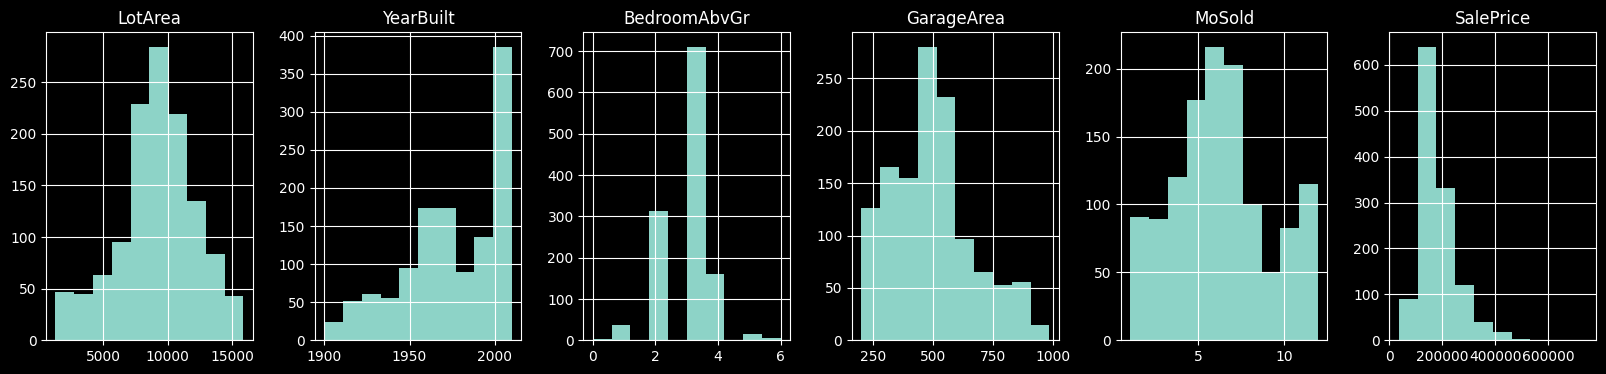

In [214]:
fig, axs = plt.subplots(1,6,figsize=(20,  4)) # создаем "полотно", на котором будем "рисовать" графики
#     ↑  более точная структура (почти синоним subplot). Говорим, что у нас будет 1 строка и 4 столбца

df.hist(column = num_columns_new, ax = axs);

**Нормализация**

In [215]:
DF  = df.copy()
Xmin = df[num_columns_new].min() # находим минимум (для каждого числового признака)
Xmax = df[num_columns_new].max() # находим максимум (для каждого числового признака)
                                                # ↓ каждый столбец делится на свою разницу максимума и минимума
DF[num_columns_new] = (df[num_columns_new]- Xmin)/( Xmax - Xmin) # реализуем нормализацию. матричные операции работают
                                        # ↑ из каждого стобца вычитаем свой минимум

**Стандартизация**

In [216]:
M = DF[num_columns_new].mean() # находим среднее (для каждого числового признака)
STD = DF[num_columns_new].std() # находим стандартное отклонение (для каждого числового признака)
DF[num_columns_new] = (DF[num_columns_new]-M)/STD # реализуем стандартизацию. матричные операции работают

**Степенное преобразование**

In [217]:
pt = PowerTransformer()

pt.fit(DF[num_columns_new]);

In [218]:
power = pt.transform(DF[num_columns_new])
df_power = pd.DataFrame(power, columns= num_columns_new)
df_power

,LotArea,YearBuilt,BedroomAbvGr,GarageArea,MoSold,SalePrice
0,-0.306116,1.107616,0.196830,0.426528,-1.722636,0.653393
1,0.077258,-0.121489,0.196830,-0.092431,-0.462927,0.280031
2,0.670275,1.003802,0.196830,0.743289,0.996955,0.827796
3,0.060031,-1.764715,0.196830,0.913253,-1.722636,-0.512424
4,1.847303,0.952598,1.510394,1.792297,1.968945,1.096774
...,...,...,...,...,...,...
1239,-0.475720,0.901870,0.196830,-0.092431,0.655154,0.174496
1240,1.411101,-0.044420,0.196830,0.153177,-1.722636,0.671714
1241,-0.112084,-1.174282,1.510394,-1.591973,-0.462927,1.244976
1242,0.117757,-0.941272,-1.100337,-1.687737,-0.870326,-0.465188


## Предварительная обработка категориальных признаков

**Порядковое коидрование**

In [219]:
ordinal = OrdinalEncoder()
ordinal.fit(DF[cat_columns_new]);

Ordinal_encoded = ordinal.transform(DF[cat_columns_new])
df_ordinal = pd.DataFrame(Ordinal_encoded, columns = cat_columns_new)

**One-hot кодирование многозначных признаков**

In [220]:
ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output= False)
ohe.fit(DF[cat_columns_new]);

ohe_feat = ohe.transform(DF[cat_columns_new])
#                                       ↓с помощью метода получаем полные имена One-Hot кодировки
df_ohe = pd.DataFrame(ohe_feat, columns = ohe.get_feature_names_out()).astype(int)

## Pipeline

In [221]:
num_pipe_lotArea = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01,)),
    ('scaler', StandardScaler())
])
num_lotArea = ['LotArea']

num_pipe_GarArea = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01,)),
    ('scaler', StandardScaler()),
     ('power', PowerTransformer())
])
num_GarArea = ['GarageArea']

num_pipe_BAG = Pipeline([
    ('power', PowerTransformer())
])
num_BAG = ['BedroomAbvGr']

num_pipe_YB = Pipeline([
    ('power', PowerTransformer())
])
num_YB = ['YearBuilt']

num_pipe_SP = Pipeline([
    ('power', PowerTransformer())
])
num_SP = ['SalePrice']

num_pipe_moSold = Pipeline([
    ('scaler', StandardScaler())
])
num_moSold = ['MoSold']

cat_pipe_street = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])
cat_street = ['Street']

cat_pipe_util = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])
cat_util = ['Utilities']

cat_pipe_lotCon = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])
cat_lotCon = ['LotConfig']

cat_pipe_con1 = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])
cat_con1 = ['Condition1']

cat_pipe_roofSt = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])
cat_roofSt = ['RoofStyle']

# Сделаем отдельно Pipeline с числовыми признаками
preprocessors_num = ColumnTransformer(transformers=[
    ('num_lotArea', num_pipe_lotArea, num_lotArea),
    ('num_GarArea', num_pipe_GarArea, num_GarArea),
    ('num_BAG', num_pipe_BAG, num_BAG),
    ('num_YB', num_pipe_YB, num_YB),
    ('num_moSold', num_pipe_moSold, num_moSold),
])

# и Pipeline со всеми признаками
preprocessors_all = ColumnTransformer(transformers=[
    ('num_lotArea', num_pipe_lotArea, num_lotArea),
    ('num_GarArea', num_pipe_GarArea, num_GarArea),
    ('num_BAG', num_pipe_BAG, num_BAG),
    ('num_YB', num_pipe_YB, num_YB),
    ('num_moSold', num_pipe_moSold, num_moSold),
    ('cat_street', cat_pipe_street, cat_street),
    ('cat_util', cat_pipe_util, cat_util),
    ('cat_lotCon', cat_pipe_lotCon, cat_lotCon),
    ('cat_con1', cat_pipe_con1, cat_con1),
    ('cat_roofSt', cat_pipe_roofSt, cat_roofSt),
])

In [222]:
# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns = np.hstack([num_lotArea,
                    num_GarArea,
                    num_BAG,
                    num_YB,
                    num_moSold,
                    cat_street,
                    cat_util,
                    cat_lotCon,
                    cat_con1,
                    cat_roofSt,])

In [223]:
preprocessors_all.fit(DF);

# Обучение базовой модели

**Считываем данные, разбиваем на тренировочную и валидационную**

In [224]:
# не забываем удалить целевую переменную цену из признаков
X,y = DF.drop(columns = ['SalePrice']), DF['SalePrice']

# разбиваем на тренировочную и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

**Преобразуем данные**

In [225]:
# Сначала обучаем на тренировочных данных
preprocessors_num.fit(X_train)
X_train_prep = preprocessors_num.transform(X_train)
# потом на валидационной
X_val_prep = preprocessors_num.transform(X_val)

**Обучаем модель**

Связь между нашими данными нелинейная и у некоторых независимых переменных есть большая разница в значениях. Поэтому нужно использовать TransformedTargetRegressor

In [226]:
model = TransformedTargetRegressor(
        regressor=SGDRegressor(random_state = 42),
    transformer=PowerTransformer())

model.fit(X_train_prep, y_train);

# Анализируем артефакты модели

## Веса модели

In [227]:
preprocessors_num.get_feature_names_out()

preprocessors_num.get_feature_names_out()[0]

preprocessors_num.get_feature_names_out()[0].split('__')

B0, B = get_coefs(model)
features_names = [x.split('__')[1] for x in preprocessors_num.get_feature_names_out()]

Bs = np.hstack([B0,B])
vis_weigths(Bs,features_names)

Видно, что смещения почти нет. Наибольший вес у признака YearBuilt. Это говорит о том, что год постройки объекта является самым значимым фактором для модели. Вторым по важности идет признак LotArea, площадь участка также является важным фактором для оценки недвижимости. Третьим по важности идет GarageArea. Логично, что наличие и размер гаража могут существенно вляить на стоимость недвижимости.
Меньше всего влияет на цену количество спален (BedroomAbvGr), так как месяц продажи сложно оценить.

## Распределение предсказания

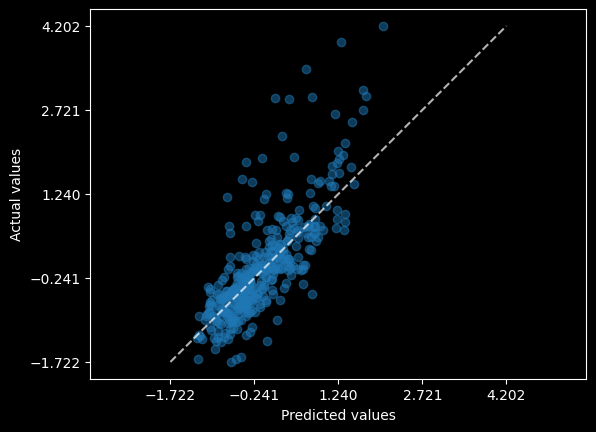

In [228]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
line_kwargs = {"color" : 'white'}
);

Модель показывает неплохую точность, так как точки располагаются близко к диагонали, но есть несколько выбросов.

## Оценка метрик и кросс-валидация

In [229]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

cv_rule = ShuffleSplit(n_splits=5, random_state = 42)

metrics = [mse, r2_score]

metric_names = ['mse', 'r2_score']

In [230]:
#@title Регуляризация { run: "auto" }
#@markdown ### Тип регуляризации
regularization=Ridge  #@param [ "Lasso" , "Ridge"]{type:"raw"}
#@markdown ### Константа Регуляризации (в виде 10^alpha)
alpha=5#@param {type:"slider", min:-5, max:5, step:0.25}
# аккуратно с большими значениями ( > 3.5)
alpha = 10**alpha

model = regularization(alpha = alpha, random_state = 42)

model.fit(X_train_prep, y_train);


analyse_linear_model(model,
              X_train_prep, y_train,
              X_val_prep, y_val,
              metrics, metric_names,
              scoring_reg, cv_rule)

Решение
0.020+0.00*LotArea+0.00*GarageArea+0.00*BedroomAbvGr+0.01*YearBuilt+0.00*MoSold


mse на тренировочной выборке: 1.0323
mse на валидационной выборке: 0.8734
r2_score на тренировочной выборке: 0.0148
r2_score на валидационной выборке: 0.0112
Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.040615,0.022764,0.005003,-0.590161,-0.654376,-1.950737
1,0.034966,0.042089,0.005712,-1.522558,-0.763636,-7.775526
2,0.010403,0.004779,0.010783,-1.263397,-0.792548,-5.914403
3,0.019780,0.013696,0.016593,-0.790165,-0.699369,-2.678308
4,0.004811,0.004287,0.014136,-0.750868,-0.676253,-2.302677




test_R2      0.010445
test_-MSE   -0.983430
test_-MAE   -0.717236
test_-Max   -4.124330
dtype: float64


Модель показывает крайне низкий коэффициент детерминации r2, что говорит о почти полном отсутствии объясненной дисперсии целевой переменной на тестовых данных. Значения MSE, MAE и MaxError указывают на плохую способность модели предсказывать значения, так как ошибки значительны. Будем улучшать модель

# Добавляем новые признаки

## Оценим оптимальное число кластеров методом Локтя

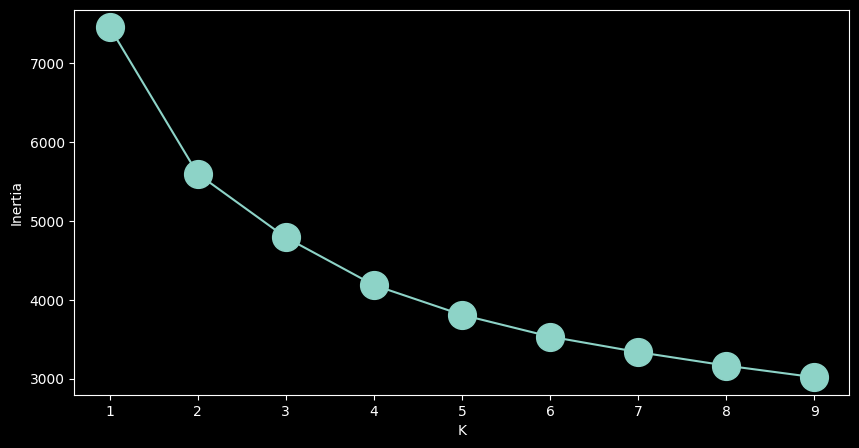

In [231]:
dataframe = DF[num_columns_new]
X = dataframe.values

sse = [] # здесь будем хранить инерции для конкретных к
list_k = list(range(1, 10))
for k in list_k: # тестируем различные к в диапазоне от 1 до 10
    km = KMeans(n_clusters=k, # создаем объект кластеризации с заданным к
            n_init = 10)
    km.fit(X) # обучаем
    sse.append(km.inertia_) # фиксируем текущую инерцию

# визуализируем метод локтя

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o', markersize = 20)
plt.xlabel('K')
plt.ylabel('Inertia');

Попробуем сделать 3 кластера

## Кластеризация K-Means

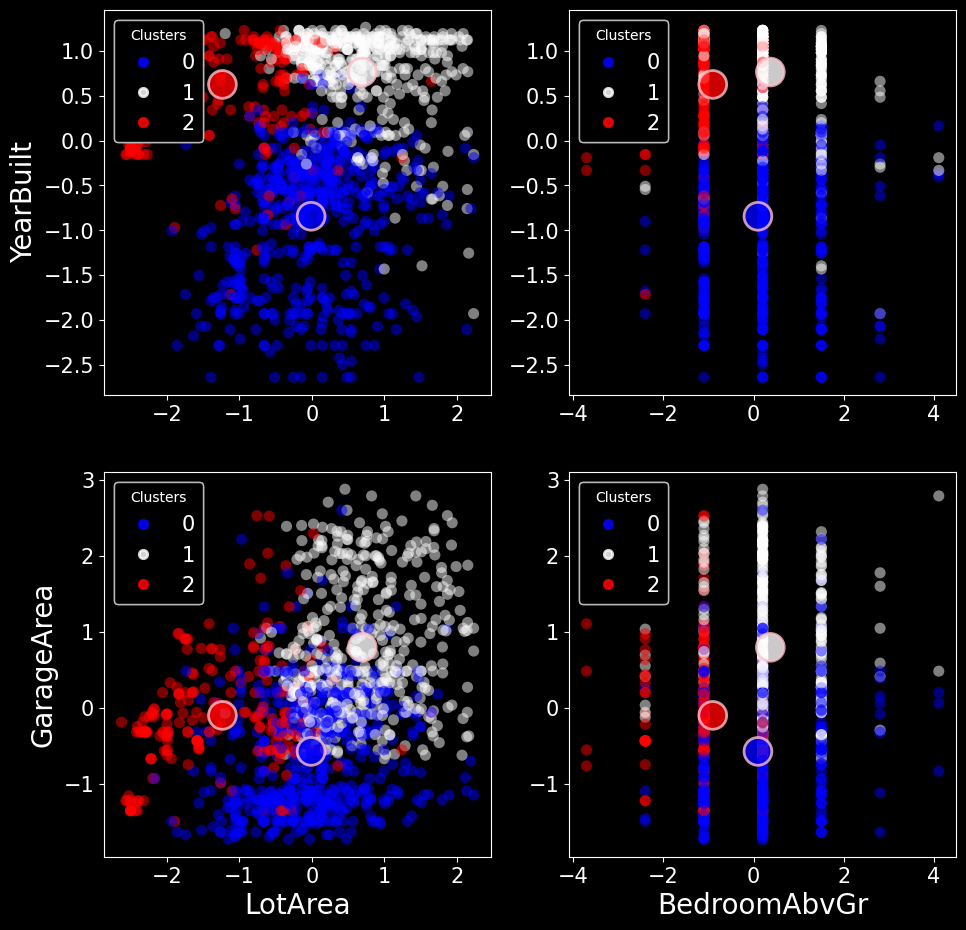

In [232]:
dataframe = DF[num_columns_new]
k = 3

X = dataframe.values

km = KMeans(n_clusters=k,
            n_init = 10)

km.fit(X)
labels = km.predict(X)
centroids = km.cluster_centers_
label_centroids = km.predict(centroids)

fig, sub = plt.subplots(2, 2, figsize = (11,11))
plot_multi(X, labels,
           dataframe.columns,
           sub, size = 64);

plot_multi(centroids, label_centroids,
           dataframe.columns,
           sub,
           alpha = 0.8,
           size = 400,
           edgecolors = 'pink');

Добавляем признаки связанные с кластером

In [233]:
DF_cluster = pd.DataFrame(km.transform(DF[num_columns_new]))
DF_cluster['cluster'] = km.predict(DF[num_columns_new])
DF_cluster

,0,1,2,cluster
0,2.811262,2.093465,2.272364,1
1,1.272314,1.735074,1.910860,0
2,2.779307,1.016416,2.743177,1
3,2.508745,3.705651,3.722536,0
4,4.652167,2.815116,5.028736,1
...,...,...,...,...
1239,1.990081,1.894674,1.588687,2
1240,2.600554,2.141372,3.276437,1
1241,2.510075,3.307728,3.792475,0
1242,1.750879,3.658593,2.621286,0


Преобразуем числовые признаки в виде расстояния до центров кластеров

In [234]:
# Создаем копию для числовых признаков
distance_features = DF_cluster.iloc[:, :-1]  # Все столбцы, кроме 'cluster'
scaler = StandardScaler()

# Масштабируем расстояния
distance_scaled = scaler.fit_transform(distance_features)

# Преобразуем обратно в DataFrame
distance_scaled_df = pd.DataFrame(distance_scaled, columns=[f'Distance_to_Cluster_{i}' for i in range(distance_features.shape[1])])

# Обновляем DataFrame с обработанными расстояниями
DF_cluster = pd.concat([distance_scaled_df, DF_cluster[['cluster']]], axis=1)

Добавляем обработанные признаки к исходным данным

In [235]:
DF = pd.concat([DF, DF_cluster], axis=1)

# Подбирем оптимальные гиперпараметры с помощью рандомизированного поиска

In [236]:
# словарь гиперпараметров в виде
# обозначение гиперпараметров : из какого распределения сэмплируем
# обозначение должно "досимвольно" совпадать с тем что в документации
alpha_range = loguniform(1e-5, 1e5)

tuned_parameters = [{'alpha':  alpha_range }]

# количество итераций
n_iter_search = 20

Ridge_search = RandomizedSearchCV(estimator = Ridge(random_state = 42),  # оптимизируем нашу модель
                                verbose = 3,  # чтобы он всё подробно расписал. если не интересно - пишем 0
                          param_distributions=tuned_parameters , # что оптимизируем - берем из словарика
                          cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                          n_iter = n_iter_search # количество итераций
                          )

In [237]:
Ridge_search.fit(X_train_prep, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ..........alpha=116.61897134117277;, score=0.514 total time=   0.0s
[CV 2/5] END ..........alpha=116.61897134117277;, score=0.362 total time=   0.0s
[CV 3/5] END ..........alpha=116.61897134117277;, score=0.492 total time=   0.0s
[CV 4/5] END ..........alpha=116.61897134117277;, score=0.653 total time=   0.0s
[CV 5/5] END ..........alpha=116.61897134117277;, score=0.538 total time=   0.0s
[CV 1/5] END ........alpha=0.008030603144479192;, score=0.504 total time=   0.0s
[CV 2/5] END ........alpha=0.008030603144479192;, score=0.358 total time=   0.0s
[CV 3/5] END ........alpha=0.008030603144479192;, score=0.504 total time=   0.0s
[CV 4/5] END ........alpha=0.008030603144479192;, score=0.640 total time=   0.0s
[CV 5/5] END ........alpha=0.008030603144479192;, score=0.532 total time=   0.0s
[CV 1/5] END ........alpha=0.001177198011346185;, score=0.504 total time=   0.0s
[CV 2/5] END ........alpha=0.001177198011346185

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
                   estimator=Ridge(random_state=42), n_iter=20,
                   param_distributions=[{'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b9414d63160>}],
                   verbose=3)

In [238]:
Ridge_search.best_estimator_

Ridge(alpha=116.61897134117277, random_state=42)

In [239]:
Ridgebest=Ridge_search.best_estimator_

Ridgebest.fit(X_train_prep, y_train);

In [240]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

cv_rule = ShuffleSplit(n_splits=5, random_state = 42)

metrics = [mse, r2_score]

metric_names = ['mse', 'r2_score']

In [241]:
analyse_linear_model(Ridgebest,
              X_train_prep, y_train,
              X_val_prep, y_val,
              metrics, metric_names,
              scoring_reg, cv_rule)

Решение
0.020+0.21*LotArea+0.27*GarageArea+0.09*BedroomAbvGr+0.42*YearBuilt+0.04*MoSold


mse на тренировочной выборке: 0.4884
mse на валидационной выборке: 0.3857
r2_score на тренировочной выборке: 0.5339
r2_score на валидационной выборке: 0.5634
Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.012447,0.005680,0.514057,-0.288227,-0.425480,-1.410837
1,0.004940,0.010337,0.361617,-0.977558,-0.505870,-7.531050
2,0.011464,0.006833,0.492271,-0.648456,-0.512277,-4.855906
3,0.007643,0.008584,0.652501,-0.279215,-0.395781,-1.542412
4,0.002653,0.014231,0.537761,-0.352057,-0.456674,-1.834806




test_R2      0.511641
test_-MSE   -0.509103
test_-MAE   -0.459216
test_-Max   -3.435002
dtype: float64


Видно, что метрики модели значительно улучшились. Метрики ошибок уменьшились, а r2 увеличился

In [242]:
DF_reg=pd.DataFrame(Ridge_search.cv_results_)
DF_reg

DF = DF_reg[['param_alpha',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("purple", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_alpha,mean_test_score,std_test_score,rank_test_score
0,116.618971,0.511641,0.093179,1
3,147.689642,0.511145,0.093702,2
14,15.313464,0.508785,0.090626,3
10,3.273889,0.507838,0.090229,4
18,2.259082,0.507750,0.090195,5
5,2.136725,0.507740,0.090191,6
8,1.773974,0.507708,0.090178,7
9,1.227411,0.507660,0.090160,8
15,0.013918,0.507553,0.090118,9
1,0.008031,0.507552,0.090118,10


Выходит неообучение. Скорее всего, модель без регуляризации работать будет лучше

# Подбираем оптимальные гиперпараметры по сетке параметров

In [243]:
pipe_all_transform = Pipeline([
    ('preprocessors', preprocessors_all),
    ('model', TransformedTargetRegressor( regressor=Lasso(random_state = 42),
    transformer=PowerTransformer())
    )
])

pipe_all_transform

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_lotArea',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea']),
                                                 ('num_GarArea',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['GarageArea']),
                                                 ('num...
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Condition1']),
                                                 ('cat_roofSt',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['RoofStyle'])])),
                ('model',
                 TransformedTargetRegressor(regressor=Lasso(random_state=42),
                                            transformer=PowerTransformer()))])

In [244]:
alpha_range = 10**np.linspace(-3, 3,5)

param_grid = {
    # ВАЖНО используем "имена" которые есть у компонент Pipeline и разделяем их __ (две земли)
    "preprocessors__num_lotArea__QuantReplace__threshold": [0, 0.01],
    "preprocessors__num_GarArea__QuantReplace__threshold": [0, 0.001],
    "model__regressor__alpha": alpha_range,
}

In [245]:
scorer = make_scorer(r2_score)

In [246]:
Pipe_GS = GridSearchCV(estimator = pipe_all_transform, # оптимизируем наш pipeline
                       param_grid=param_grid , # что оптимизируем - берем из словарика
                       cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                       scoring = scorer, # указываем метрику которую оптимизируем
                       verbose = 3 # чтобы он всё подробно расписал. если не интересно - пишем 0
                       )
Pipe_GS

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('preprocessors',
                                        ColumnTransformer(transformers=[('num_lotArea',
                                                                         Pipeline(steps=[('QuantReplace',
                                                                                          QuantileReplacer(threshold=0.01)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LotArea']),
                                                                        ('num_GarArea',
                                                                         Pipeline(steps=[('QuantReplace',
                                                                                          QuantileReplacer...
                                                                   transformer=PowerTransformer()))]),
             param_grid={'model__regressor__alpha': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'preprocessors__num_GarArea__QuantReplace__threshold': [0,
                                                                                 0.001],
                         'preprocessors__num_lotArea__QuantReplace__threshold': [0,
                                                                                 0.01]},
             scoring=make_scorer(r2_score, response_method='predict'),
             verbose=3)

In [247]:
Pipe_GS.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END model__regressor__alpha=0.001, preprocessors__num_GarArea__QuantReplace__threshold=0, preprocessors__num_lotArea__QuantReplace__threshold=0;, score=0.661 total time=   0.2s
[CV 2/5] END model__regressor__alpha=0.001, preprocessors__num_GarArea__QuantReplace__threshold=0, preprocessors__num_lotArea__QuantReplace__threshold=0;, score=0.565 total time=   0.3s
[CV 3/5] END model__regressor__alpha=0.001, preprocessors__num_GarArea__QuantReplace__threshold=0, preprocessors__num_lotArea__QuantReplace__threshold=0;, score=0.628 total time=   0.3s
[CV 4/5] END model__regressor__alpha=0.001, preprocessors__num_GarArea__QuantReplace__threshold=0, preprocessors__num_lotArea__QuantReplace__threshold=0;, score=0.729 total time=   0.2s
[CV 5/5] END model__regressor__alpha=0.001, preprocessors__num_GarArea__QuantReplace__threshold=0, preprocessors__num_lotArea__QuantReplace__threshold=0;, score=0.649 total time=   0.2s
[CV 1/5]

In [248]:
Pipe_best=Pipe_GS.best_estimator_
Pipe_best

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_lotArea',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea']),
                                                 ('num_GarArea',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0)),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['GarageArea']),
                                                 ('num_BAG',...
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Condition1']),
                                                 ('cat_roofSt',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['RoofStyle'])])),
                ('model',
                 TransformedTargetRegressor(regressor=Lasso(alpha=0.001,
                                                            random_state=42),
                                            transformer=PowerTransformer()))])

In [249]:
Pipe_best.fit(X_train, y_train);

In [250]:
print(f"r2 на тренировочной выборке: {calculate_metric(Pipe_best, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(Pipe_best, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(Pipe_best, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(Pipe_best, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.6439
r2 на валидационной выборке: 0.6452
mse на тренировочной выборке: 0.3731
mse на валидационной выборке: 0.3134


С этим явно лучше

# Анализируем результат

**на уровне гиперпараметров**

In [251]:
DF_Pipe = pd.DataFrame(Pipe_GS.cv_results_)
DF_Pipe.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__regressor__alpha',
       'param_preprocessors__num_GarArea__QuantReplace__threshold',
       'param_preprocessors__num_lotArea__QuantReplace__threshold', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [252]:
DF_ = DF_Pipe[[ # берем только гиперпараметры,
       'param_model__regressor__alpha',
       'param_preprocessors__num_lotArea__QuantReplace__threshold',
       'param_preprocessors__num_GarArea__QuantReplace__threshold',
                 'mean_test_score', #среднее значение метрики на кросс-валидации
             'std_test_score', # разбросс метрики на кросс-валидации
             'rank_test_score',# место
             ]]
cm = sns.light_palette("orange", as_cmap=True) # делаем подсцветку по значению. В этот раз "50 оттенков Оранжевого"
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm) # сортируем по убыванию места и раскрашиваем
hl

,param_model__regressor__alpha,param_preprocessors__num_lotArea__QuantReplace__threshold,param_preprocessors__num_GarArea__QuantReplace__threshold,mean_test_score,std_test_score,rank_test_score
0,0.001000,0.000000,0.000000,0.646425,0.052807,1
2,0.001000,0.000000,0.001000,0.645457,0.052936,2
1,0.001000,0.010000,0.000000,0.622377,0.102852,3
3,0.001000,0.010000,0.001000,0.621600,0.102768,4
4,0.031623,0.000000,0.000000,0.598888,0.061094,5
6,0.031623,0.000000,0.001000,0.597894,0.061183,6
5,0.031623,0.010000,0.000000,0.578749,0.107340,7
7,0.031623,0.010000,0.001000,0.578045,0.107391,8
17,1000.000000,0.010000,0.000000,-0.046769,0.010964,9
16,1000.000000,0.000000,0.000000,-0.046769,0.010964,9


Лучшей комбинацией гиперпараметров оказались значения: alpha = 0.001, LotArea threshold = 0.0 и GarageArea threshold = 0.0, при которых средний тестовый результат составил 0.6464. Низкое значение std_test_score (0.052807) указывает на стабильность результатов кросс-валидации. Комбинации с большими значениями alpha (например, 1000.0) показали отрицательные метрики, что свидетельствует о переобобщении или недообучении модели. На качество модели существенно влияют параметры LotArea threshold и GarageArea threshold, а наилучшие результаты достигаются при минимальном значении alpha.

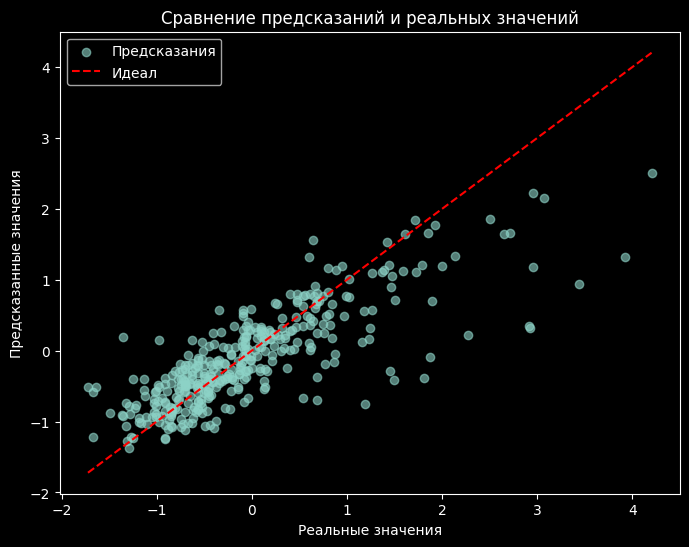

In [253]:
# Предсказания модели
y_pred = Pipe_best.predict(X_val)

# Сравнение предсказаний и реальных значений
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.6, label="Предсказания")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', label="Идеал")
plt.xlabel("Реальные значения")
plt.ylabel("Предсказанные значения")
plt.legend()
plt.title("Сравнение предсказаний и реальных значений")
plt.show()

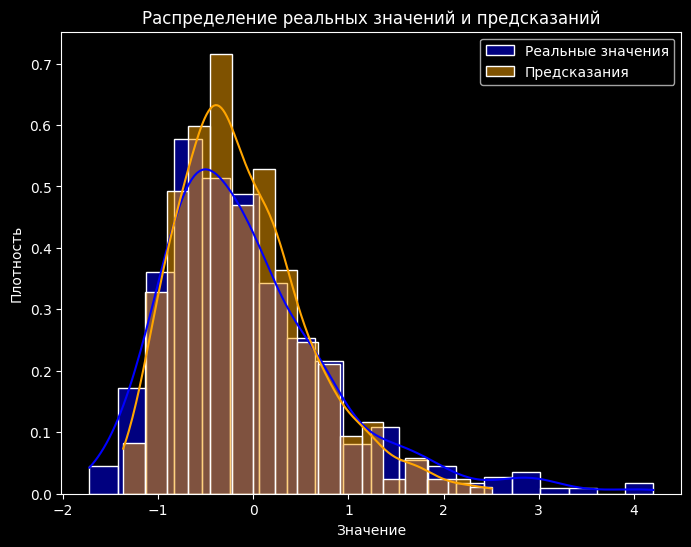

In [254]:
# Построение гистограмм
plt.figure(figsize=(8, 6))
sns.histplot(y_val, kde=True, color="blue", label="Реальные значения", stat="density")
sns.histplot(y_pred, kde=True, color="orange", label="Предсказания", stat="density")
plt.legend()
plt.title("Распределение реальных значений и предсказаний")
plt.xlabel("Значение")
plt.ylabel("Плотность")
plt.show()

Очень неплохо

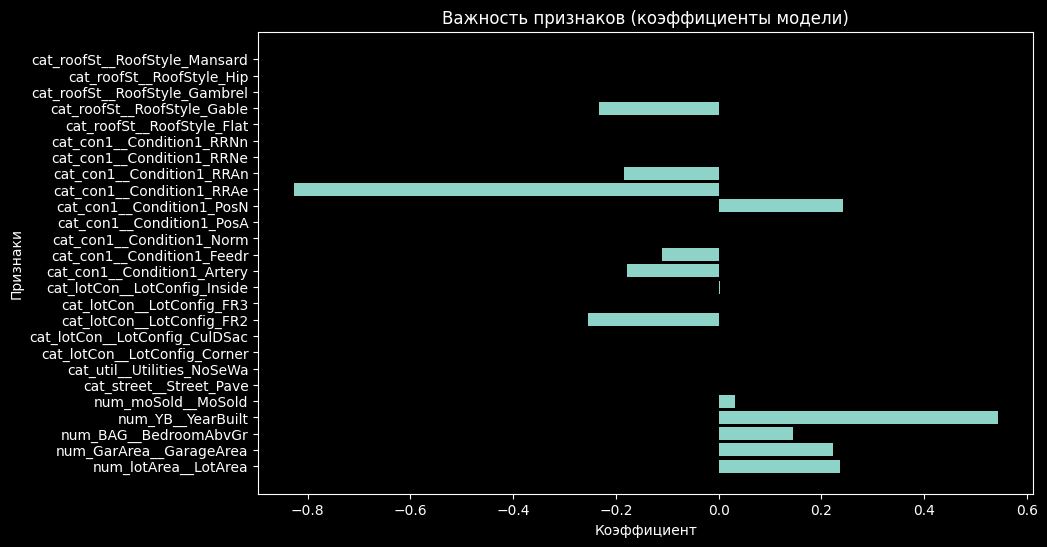

In [255]:
# Получение имен признаков после преобразования пайплайна
feature_names = Pipe_best.named_steps['preprocessors'].get_feature_names_out()

# Получение коэффициентов модели
feature_importances = Pipe_best.named_steps['model'].regressor_.coef_

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.title("Важность признаков (коэффициенты модели)")
plt.xlabel("Коэффициент")
plt.ylabel("Признаки")
plt.show()

Неожиданно, месяц продажи имеет большой коэффициент важности

In [256]:
# Вычисление ошибок
errors = np.abs(y_val - y_pred)

# Индексы лучших и худших предсказаний
best_predictions_idx = np.argsort(errors)[:10]  # 10 лучших
worst_predictions_idx = np.argsort(errors)[-10:]  # 10 худших

# Извлечение соответствующих объектов
best_predictions = X_val.iloc[best_predictions_idx]
worst_predictions = X_val.iloc[worst_predictions_idx]

# Вывод описательной статистики для лучших и худших предсказаний
print("Лучшие предсказания:")
print(best_predictions.describe())
print("\nХудшие предсказания:")
print(worst_predictions.describe())

Лучшие предсказания:
         LotArea  YearBuilt  BedroomAbvGr  GarageArea     MoSold
count  10.000000  10.000000     10.000000   10.000000  10.000000
mean   -0.070913   0.100805      0.201072   -0.267313   0.845348
std     0.975636   1.066050      1.063716    0.536982   0.883600
min    -2.418262  -2.284557     -1.101708   -1.488131  -0.498853
25%    -0.328100  -0.199140     -0.776013   -0.506539   0.247926
50%     0.090266   0.395426      0.201072   -0.183261   0.808009
75%     0.367288   0.901251      1.178158    0.047443   1.648134
max     1.087010   1.087607      1.503853    0.416275   2.114871

Худшие предсказания:
         LotArea  YearBuilt  BedroomAbvGr  GarageArea     MoSold
count  10.000000  10.000000     10.000000   10.000000  10.000000
mean    0.880128   0.260539     -0.580596    0.390412   0.247926
std     1.106667   0.984283      1.647902    1.047744   0.980023
min    -1.195834  -1.255160     -2.404489   -1.417598  -1.245631
25%     0.151938  -0.429867     -2.078794   -0.

Лучшие предсказания модели связаны с более компактными распределениями признаков, особенно для GarageArea и MoSold, которые имеют меньшее стандартное отклонение. Худшие предсказания характеризуются большей дисперсией, особенно для BedroomAbvGr, что может указывать на высокую вариативность в данных или слабую зависимость от этого признака. В среднем, модель дает лучшие результаты при менее экстремальных значениях признаков, таких как LotArea и GarageArea.

# Выводы

Подбор гиперпараметров с помощью рандомизированного поиска значительно улучшил модель. Однако модель с регуляризацией все равно имеет недообучение. Поиск гиперпараметров по сетке параметров также значительно улучшил модель.